*19 juillet 2018*

# Utilisation d'un modèle de régression multiple pour prévoir la consommation électrique.

La prédiction de série temporelle est un problème courant de Data Science. Cela consiste à expliquer l'évolution d'une variable dans le temps, pour être en capacité de prévoir sa valeur à un temps futur donné. Par exemple: un chiffre d'affaire mensuel, une affluence clientèle par tranche horaire, le cours d'une valeur boursière etc.

Une approche très populaire repose sur les fameux LSTM-RNN: un type de réseau de neurones récurrents capable de saisir et conserver l'information contextuelle d'une valeur, à long terme.
Malgré leurs performances, ils ne sont pas adaptés à tous les cas de figure. Ils sont adaptés pour, à partir d'un motif temporel correctement detecté, prévoir la prochaine étape. Par exemple, soit 10 ans d'historique d'une valeur mensuelle, quel est le résultat attendu le mois prochain ?

Par contre, pour estimer les résultats pour les 12 prochains mois, un problème se pose. Les LSTM-RNN s'appuient sur les étapes qui précèdent tout juste l'étape à prédire. Alors comment projeter toute une année d'une variable à partir de son historique ? S'il existe un set de variables explicatives, on aura tout de suite l'intuition que ce problème peut en fait se traiter comme un problème de regression classique. Tout en tenant compte de la nature temporelle des données : la variable cible répond-elle à des effets saisonniers significatifs ? Si oui il faut les modéliser. Peut-être la corrélation entre la variable et la saisonnalité est-elle tellement forte que cette dernière représente le paramètre le plus important. La variable cible présente-t-elle une tendance ?

Dans cet article, je vais expliquer comment utiliser une méthode de régression avec Python pour modéliser un phénomène cyclique, multi-saisonnier. Nous en profiterons pour couvrir les bonnes pratiques pour manipuler ce type de jeu de donnée avec Python.

## 1. Prérequis
**Python 2.7** ou **3**, avec les bibliothèques **matplotlib**, **numpy**, **pandas**, **seaborn** (facultatif) et **scikit-learn**. Nous travaillons avec un notebook **Jupyter**.

## 2. Préparations des données
*Je vais détailler pas à pas les corrections apportées au jeu de donnée d'origine et l'échantillonage de la série temporelle avec Pandas. Vous pouvez passer directement au point* * **3** * *pour l'aspect modélisation.*

La variable cible sera la **Consommation annuelle brute d’électricité**. L'historique, de 2008 à 2017 est mis à disposition par **RTE**. Il est disponible sur https://www.data.gouv.fr/fr/datasets/consommation-quotidienne-brute-delectricite-depuis-janvier-2008/ au format csv (consommation-quotidienne-brute-elec.csv).

Commençons par quelques constats et vérifications basiques sur le jeu de donnée. J'utilise naturellement **Pandas** pour transformer les données et **Matplotlib / Pyplot** pour les visualiser. **Seaborn** est également très pratique pour visualiser les statistiques des variables, alors ne nous privons pas. Et bien sur, j'importe également **Numpy**, cela servira forcément.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Seulement pour les utilisateurs de Jupyter:
from IPython.core.display import display, Markdown
%matplotlib inline

# Facultatif: pour mettre votre notebook en pleine largeur écran:
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Un petit coup d’œil au fichier pour voir comment l'importer (commande shell linux).

```!head -n 4 consommation-quotidienne-brute-elec.csv```

```
Date - Heure;Date;Heure;Consommation (MW);Qualité
2008-01-21T22:00:00+01:00;2008-01-21;22:00;62685.403;Définitive
2008-01-21T23:00:00+01:00;2008-01-21;23:00;64155.076;Définitive
2008-01-21T23:30:00+01:00;2008-01-21;23:30;62318.682;Définitive
```

Le premier champ contient les dates au format ISO 8601, je peux le parser directement et le passer en index. Par contre les deux champs suivants Date et Heure ne font que répéter l'information. Je les laisse de côté. Je renomme aussi les variables pour alléger les futurs appels.

In [2]:
df = pd.read_csv('consommation-quotidienne-brute-elec.csv',
                 sep=';',
                 usecols=[0,3,4],
                 index_col=0, 
                 header=0,
                 names=['date','conso', 'qualite'],
                 parse_dates=[0],
                 infer_datetime_format=True)

df.head(2)

,conso,qualite
date,,
2008-01-21 21:00:00,62685.403,Définitive
2008-01-21 22:00:00,64155.076,Définitive


Vérifions rapidement les données, je m'intéresserai à l'index dans un second temps.

conso      False
qualite    False
dtype: bool
               conso
count  182592.000000
mean    55348.791753
std     12206.856852
min     29477.000000
25%     46046.000000
50%     53738.000000
75%     63836.973000
max    102098.000000


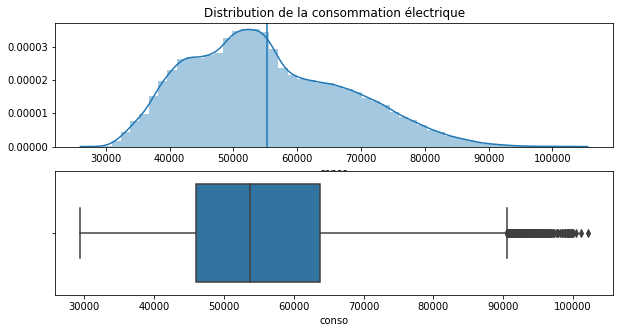

In [3]:
# Existence de données manquantes ?
print(df.isnull().any())

# Description de la variable conso
print(df.describe())
f, ax = plt.subplots(2, figsize=(10,5))
sns.distplot(df.conso, ax=ax[0])
ax[0].axvline(df.conso.mean())
sns.boxplot(df.conso, ax=ax[1])
ax[0].set_title('Distribution de la consommation électrique')
plt.show()

Bien ça semble propre. Pas de données manquantes. Il y a bien quelques valeurs extrêmes hautes qui seront peut-être difficiles à attraper, mais rien de ridicule. Voyons maintenant le champ "qualite". D'après RTE, la qualité "Intermédiaire" indique les valeurs qui n'ont pas été corrigées de leur part.

In [4]:
print(df.qualite.value_counts(), '\n')
print(df[df.qualite == "Définitive"].index.min(), 
      df[df.qualite == "Définitive"].index.max())
print(df[df.qualite == "Intermédiaire"].index.min(), 
      df[df.qualite == "Intermédiaire"].index.max())

Définitive       157824
Intermédiaire     24768
Name: qualite, dtype: int64 

2007-12-31 23:00:00 2016-12-31 22:30:00
2016-12-31 23:00:00 2018-05-31 21:30:00


Apparement, RTE n'a pas produit les résultats corrigés à partir de 2016-12-31. Gardons ça en tête, mais *a priori* cela ne nous concerne pas dans le cas de l'exercice. Vérifions l'index du jeu de donnée à présent.

In [5]:
df.head(1).index

DatetimeIndex(['2008-01-21 21:00:00'], dtype='datetime64[ns]', name='date', freq=None)

Il est bien au format datetime, mais Pandas n'en détecte pas automatiquement la fréquence (qui est une caractéristique d'une série temporelle).


Remarquez que Pandas affiche la date UTC (offset de + 1h / 2h de notre heure d'hiver / d'été en France). C'est aussi bien comme ça, inutile d'aller expliquer à l'algo pourquoi deux lignes de données sautent ou apparaissent une fois l'an. Bien sur, on s'attend à ce que la consommation d'électricité se décale en conséquence, mais ce n'est pas en théorie pas un problème, le modèle va le prendre en compte.


Le jeu de donnée fournit une fréquence de 30 minutes. Je vais vérifier que ceci est correct. Pandas permet de faire des agrégations sur la base d'une fréquence donnée. Il y a deux méthodes : par une instance de ```pandas.Grouper``` à passer à ```Groupby```, ou plus simplement avec la méthode de dataframe ```resample```:

```
df.groupby(pd.Grouper(freq='30T')).sum()
```


ou

```
df.resample('30T').sum()
```

```pandas.Grouper``` permet de passer une colonne de date comme nouvel index temporel, si votre index représente déjà l'axe temporel souhaité, utilisez la méthode ```resample``` de la dataframe.

Voyons si nous récupérons bien toutes les données par tranche de 30 minutes. Profitons-en pour ordonner l'index. Ce n'est pas indispensable, mais aidera à la lecture.

In [6]:
df.sort_index(inplace=True)
resampled = df.resample('30T').mean()
print(df.shape[0] - resampled.shape[0])

2


Il en manque deux dans le jeu ré-échantilloné. Cela signifie qu'il y a des doublons dans l'index. Je vais les localiser.

In [7]:
# Je ne vous montre que 10 exemples
df[df.index.duplicated(keep=False)].head(10)

,conso,qualite
date,,
2008-03-30 01:00:00,54253.898,Définitive
2008-03-30 01:00:00,54253.898,Définitive
2008-03-30 01:30:00,54477.443,Définitive
2008-03-30 01:30:00,54578.725,Définitive
2009-03-29 01:00:00,55002.676,Définitive
2009-03-29 01:00:00,55002.676,Définitive
2009-03-29 01:30:00,55255.957,Définitive
2009-03-29 01:30:00,55335.263,Définitive
2010-03-28 01:00:00,52436.558,Définitive


Bon, clairement le changement d'heure d'été pose un problème. L'heure change à 1h utc au lieu de 2h utc et il y a des duplications de créneau, avec parfois une valeur de conso légèrement différente. Allons voir ce qui se passe sur cette fenêtre (en mars 2008 par exemple).
C'est le moment de montrer comment sélectionner les enregistrements par index au format date: la méthode loc est capable de parser directement une string représentant une date au format iso (on peut également passer un objet datetime python).

In [8]:
df.loc['2008-03-30T00:00':'2008-03-30T04:00']

# Également valide:
# df['2008-03-30T00:00':'2008-03-30T04:00']

,conso,qualite
date,,
2008-03-30 00:00:00,54455.317,Définitive
2008-03-30 00:30:00,54477.443,Définitive
2008-03-30 01:00:00,54253.898,Définitive
2008-03-30 01:00:00,54253.898,Définitive
2008-03-30 01:30:00,54477.443,Définitive
2008-03-30 01:30:00,54578.725,Définitive
2008-03-30 02:00:00,51792.200,Définitive
2008-03-30 02:30:00,50122.406,Définitive
2008-03-30 03:00:00,48867.596,Définitive


Ok, déjà il semble louche que les créneaux 00:30 utc et 01:30 utc partage la même valeur de consommation, au millième près. Il y a deux duplications de créneau sur cette fenêtre, pour des raisons qui m'échappe. Je ne vais pas tenter de démêler ça. Pour l'exercice, je me contente de vérifier l'écart maximum entre duplicata, puis supprimer ces derniers en gardant la première occurrence. La méthode ```pct_change()``` remplace chaque valeur par sa différence avec la précédente exprimée en pourcentage


In [9]:
np.absolute(df[df.index.duplicated(keep=False)].groupby(level=0).pct_change()).max()

conso    0.018097
dtype: float64

Il y a au maximum 0.018 % de différence entre deux créneaux dupliqués. C'est assez faible ne pas nous inquiéter. Je retire les duplicata puis je revérifie la cohérence de l'échantillonage.

In [10]:
df = df.reset_index().drop_duplicates(subset='date', keep='first').set_index('date')

resampled = df.resample('30T').mean()
print(df.shape[0] - resampled.shape[0])

-20


Maintenant, le ré-échantillonnage nous indique 20 lignes manquantes dans le jeu de donnée. Localisons-les en sélectionnant par données nulles.

In [11]:
resampled[resampled.conso.isnull()].head(10)

,conso
date,
2008-10-26 00:00:00,NaN
2008-10-26 00:30:00,NaN
2009-10-25 00:00:00,NaN
2009-10-25 00:30:00,NaN
2010-10-31 00:00:00,NaN
2010-10-31 00:30:00,NaN
2011-10-30 00:00:00,NaN
2011-10-30 00:30:00,NaN
2012-10-28 00:00:00,NaN


Le changement d'heure vers l'hiver. Allons voir.

In [12]:
df['2008-10-25T23:00:00': '2008-10-26T02:00:00']

,conso,qualite
date,,
2008-10-25 23:00:00,49014.213,Définitive
2008-10-25 23:30:00,48792.638,Définitive
2008-10-26 01:00:00,48379.072,Définitive
2008-10-26 01:30:00,44416.517,Définitive
2008-10-26 02:00:00,43087.332,Définitive


C'est un problème, d'après ce dataset, nous n'existons pas entre 0h00 utc et 1h00 utc du dernier dimanche d'octobre. Pour apporter une réponse raisonnable (à défaut de philosophique) à ce vide existentiel, je comble les créneaux manquants par une interpolation linaire. Je récupère le jeu ré-échantillonné, le champ 'qualite' a été mis de côté par Pandas lors de l'agrégation mais nous n'en avons pas besoin (on retiendra que la fin du jeu de donnée est potentiellement biaisé, mais elle n'entrera pas dans l'entraînement).

In [13]:
df = resampled.interpolate(method='linear')
display(df.head(1))
df.head(1).index

,conso
date,
2007-12-31 23:00:00,67027.829


DatetimeIndex(['2007-12-31 23:00:00'], dtype='datetime64[ns]', name='date', freq='30T')

La série temporelle est cohérente, sur une fréquence de 30 minutes.

## 3. Modélisation

Synthèse de la partie précédente, pour préparer le jeu de donnée

In [14]:
import numpy as np
import pandas as pd

df = pd.read_csv('consommation-quotidienne-brute-elec.csv',
                 sep=';',
                 usecols=[0,3,4],
                 index_col=0, 
                 header=0,
                 names=['date','conso', 'qualite'],
                 parse_dates=[0],
                 infer_datetime_format=True)

df = df.reset_index().drop_duplicates(subset='date', keep='first').set_index('date')
df = df.resample('30T').mean().interpolate(method='linear')

Voyons comment évolue la consommation électrique à différentes échelles.

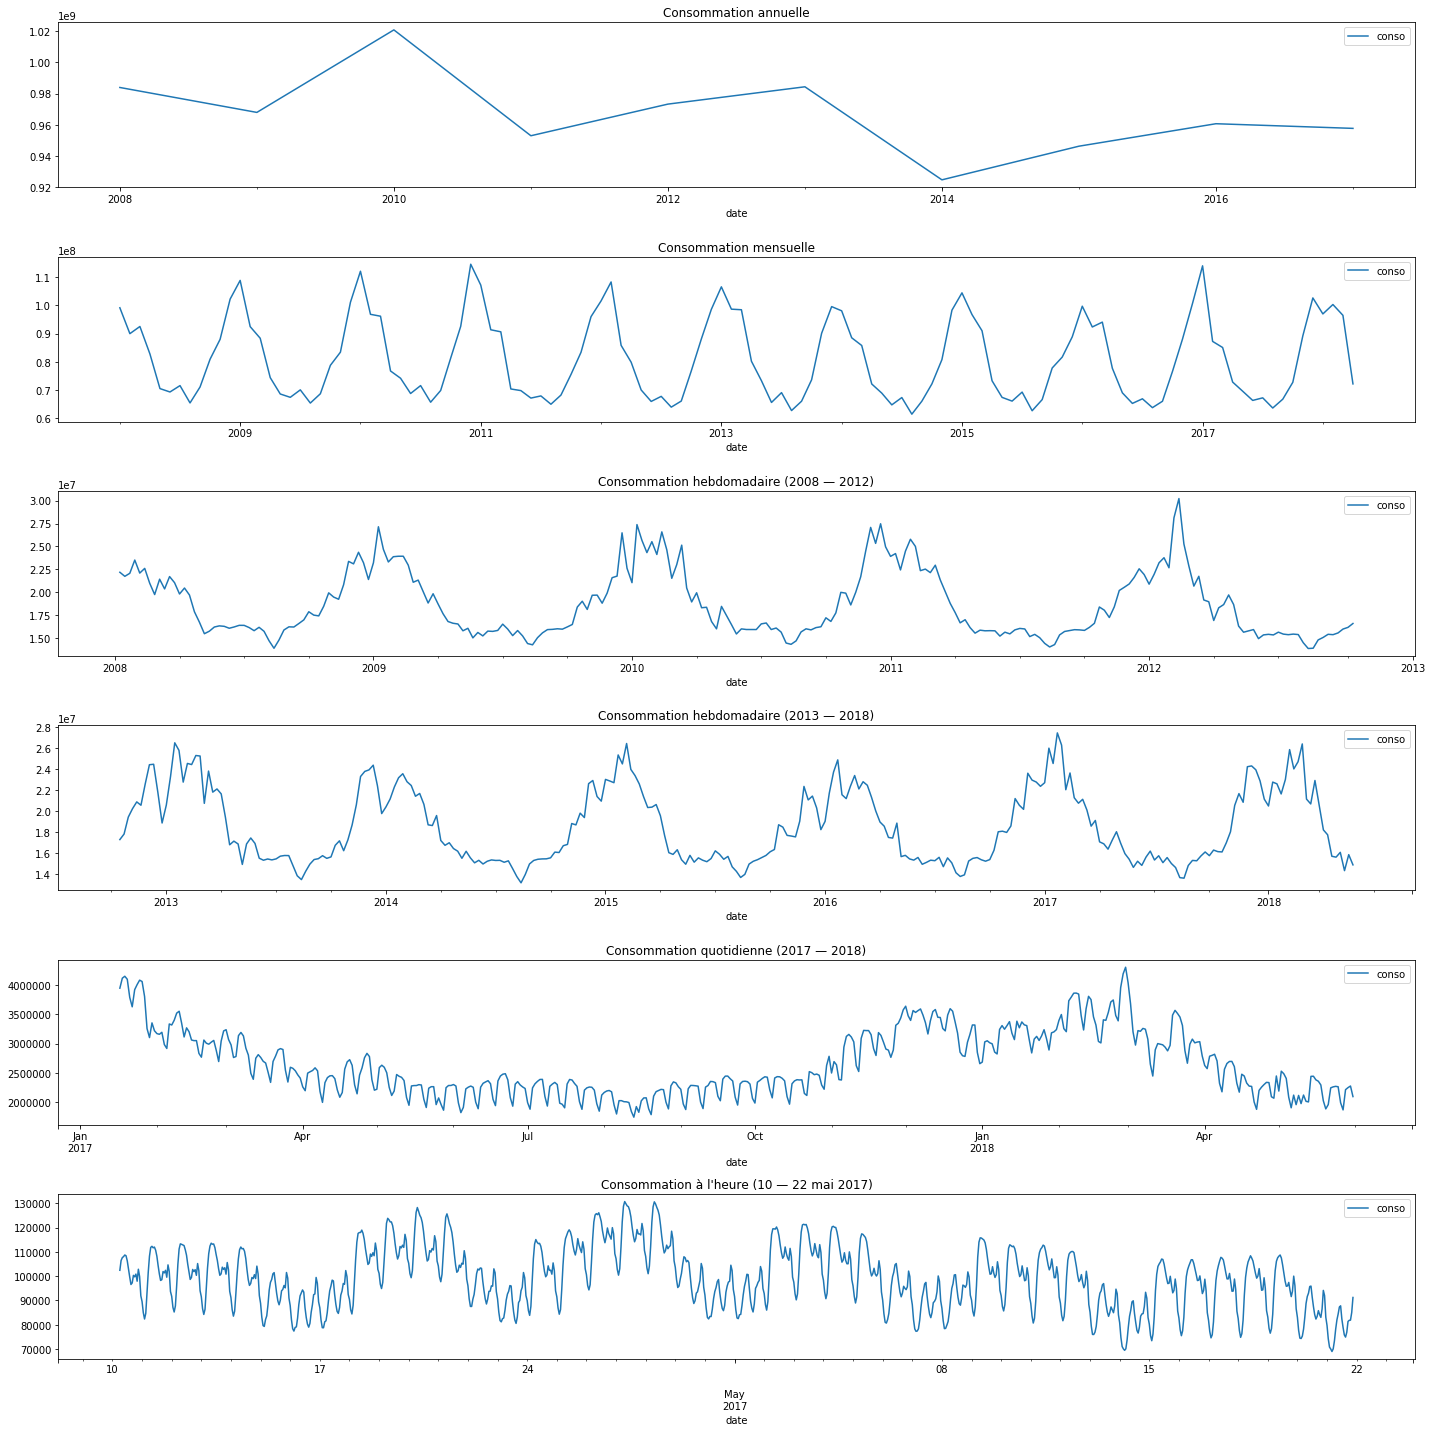

In [15]:
f, ax = plt.subplots(6,1, figsize=(20,20))
df.resample('Y').sum().iloc[1:-1].plot(ax=ax[0]).set_title("Consommation annuelle")
df.resample('M').sum().iloc[1:-1].plot(ax=ax[1]).set_title("Consommation mensuelle")
df.resample('W').sum().iloc[1:250].plot(ax=ax[2]).set_title("Consommation hebdomadaire (2008 — 2012)")
df.resample('W').sum().iloc[250:-1].plot(ax=ax[3]).set_title("Consommation hebdomadaire (2013 — 2018)")
df.resample('D').sum().iloc[-500:].plot(ax=ax[4]).set_title("Consommation quotidienne (2017 — 2018)")
df.resample('H').sum().iloc[-10000:-9000].plot(ax=ax[5]).set_title("Consommation à l'heure (10 — 22 mai 2017)")
plt.tight_layout()
plt.show()

# Je coupe les extrémités à chaque fois, pour être à bords nets.

Il semble y avoir une tendance à la décroissance de la consommation globale. Nous observons trois saisonnalités : variation annuelle, variation hebdomadaire et variation quotidienne. Clairement, on consomme plus d'électricité en hiver. La consommation est moindre le week-end, et bien entendu, la nuit.
Les paramètres du modèle doivent donc représenter : la tranche de la journée, le jour de la semaine et la semaine de l'année. Pandas permet de créer ces variables très facilement, par l'accès aux attributs de l'index datetime. Je spécifie explicitement la nature catégorique de ces variables.

Par convention, je renomme la variable cible 'y'.

Je vais ré-échantillonner le jeu de donnée à une fréquence de 1h pour limiter l'usage de la RAM et le temps de calcul. Vous pouvez rester sur 30 minutes, mais sachez que l'usage de la RAM va alors dépasser les 10 GiBs lors de l'entraînement du modèle.

In [16]:
# Pour rester à une fréquence de 30 minutes, commentez la ligne suivante.
df = df.resample('H').sum()

df.columns = ['y']

df["annuelle"] = pd.Categorical(df.index.week)
df["hebdomadaire"] = pd.Categorical(df.index.weekday)
df["journaliere"] = pd.Categorical(df.index.time.astype('str'))
# J'utilise index.time plutôt que index.hour, pour que cette ligne
# soit également appliquable à une frequence inférieure à 1h

Et comme l'algorithme de régression linaire de scikit-learn ne gère pas nativement les variables catégoriques, je les transforme manuellement en un set de variables binaires (one hot encoding) avec la fonction ```get_dummies``` de Pandas. J'active l'option 'drop_first' pour ne pas créer de couples de variables colinéaires.

Je récupère ceci dans une nouvelle dataframe 'X'. Je normalise 'y' avec ```StandardScaler``` (moyenne centrée sur zéro et réduction de la variance). La variable centrée-réduite sera appelée 'ys'.

In [17]:
X = pd.get_dummies(df[["annuelle", "hebdomadaire", "journaliere"]], drop_first=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ys = scaler.fit_transform(df['y'].values.reshape(-1, 1))
ys = pd.Series(ys.reshape(-1))
ys.index = df.index

(Les fonctions de Scikit-learn, telle que StandardScaler, renvoient les données sous forme d'objets numpy. C'est très bien, mais avec un jeu de donnée indexé sur le temps, je trouve très pratique de pouvoir sélectionner avec les dates. C'est pourquoi je préfère généralement ré-indexer une Series ou une DataFrame Pandas, au moins pendant la phase d'exploration).

Il reste encore à prendre en compte les inteactions entre les différentes saisonnalités: un dimanche de décembre ne se comporte probablement pas comme un dimanche d'août. Notez que statsmodels permet de définir des formules de régression dans le style de R. ```PolynomialFeatures``` de scikit-learn permet de récuperer toutes les interactions d'un set de variables, mais j'ai besoin d'un peu plus de contrôle. Je vais composer les interactions qui nous intéressent manuellement. Pour éviter de générer des variables colinéaires, j'omet à chaque fois une des variables à chaque niveau de saisonnalité.

In [18]:
# Intéractions entre jours et semaines:
def interact_HxJ():
    for hebdo in X.columns[53:58]:
        for journ in X.columns[59:]:
            yield X[hebdo] * X[journ]
HxJ = pd.concat(interact_HxJ(), axis=1)

# Intéractions entre années et semaines:
def interact_AxH():
    for hebdo in X.columns[53:58]:
        for annee in X.columns[:51]:
            yield X[hebdo] * X[annee]
AxH = pd.concat(interact_AxH(), axis=1)

def interact_JxA():
    for journ in X.columns[59:]:
        for annee in X.columns[:51]:
            yield X[journ] * X[annee]
JxA = pd.concat(interact_JxA(), axis=1)

X = pd.concat((X, AxH, HxJ, JxA), axis = 1)

Pour contrôler l'espace occupé par le jeu de donnée.

In [19]:
print('{} GiB'.format(round(X.memory_usage().sum() / 1000**3, 2)))

0.14 GiB


Il est temps de tester une régression. Essayons de prédire 2016 avec les années précédentes, puis 2017 de la même manière.

In [20]:
X_train, X_test = X[:'2016-01-01'], X['2016-01-01':'2017-01-01']
ys_train, ys_test = ys[:'2016-01-01'], ys['2016-01-01':'2017-01-01'] 

from sklearn.linear_model import LinearRegression as lr

mlr = lr(fit_intercept = False).fit(X_train, ys_train)
print("R Squared: {} %".format(round(mlr.score(X_train, ys_train)*100,2)))

R Squared: 88.12 %


Le R-Squared des valeurs estimées est plutôt correct. Regardons tout de suite l'erreur de prédiction. Je définis une petite fonction qui affiche un set de mesures d'erreur courantes au format Markdown. Si vous n'utilisez pas Jupyter, adaptez en conséquence.

In [21]:
def print_error_measures(y_test, preds, show = True):
    errors = y_test - preds
    r2 = lambda x: round(x,2)
    mse = (errors ** 2).mean()
    rmse = np.sqrt((errors ** 2).mean())
    mae = np.abs(errors).mean()
    rmpse = np.sqrt((errors ** 2).mean())
    mape = np.abs(errors / y_test.sum()).sum() * 100
    wape = np.abs(errors).sum() / y_test.sum() * 100
    
    if show:  
        print('mse: mean squared error; rmse: root mean squared error ; mae: mean absolute error; '
          'mape: mean absolute percentage error; wape: weighted absolute percentage error')
        display(Markdown(
            "Measure|Value\n"
            "--|--\n"
            "mse|{}\n"
            "rmse|{}\n"
            "mae|{}\n"
            "mape|{} %\n"
            "wape|{} %\n".format(r2(mse), r2(rmse), r2(mae), r2(mape), r2(wape))
        ))
    return (mse, rmse, mae, mape, wape)

In [22]:
preds = mlr.predict(X_test)

preds = scaler.inverse_transform(preds)
y_test = scaler.inverse_transform(ys_test)
print_error_measures(preds, y_test);

mse: mean squared error; rmse: root mean squared error ; mae: mean absolute error; mape: mean absolute percentage error; wape: weighted absolute percentage error


Measure|Value
--|--
mse|58260356.68
rmse|7632.85
mae|5600.77
mape|5.07 %
wape|5.07 %


Une erreur moyenne de 5.07 % semble assez satisfaisante. Affichons les courbes.

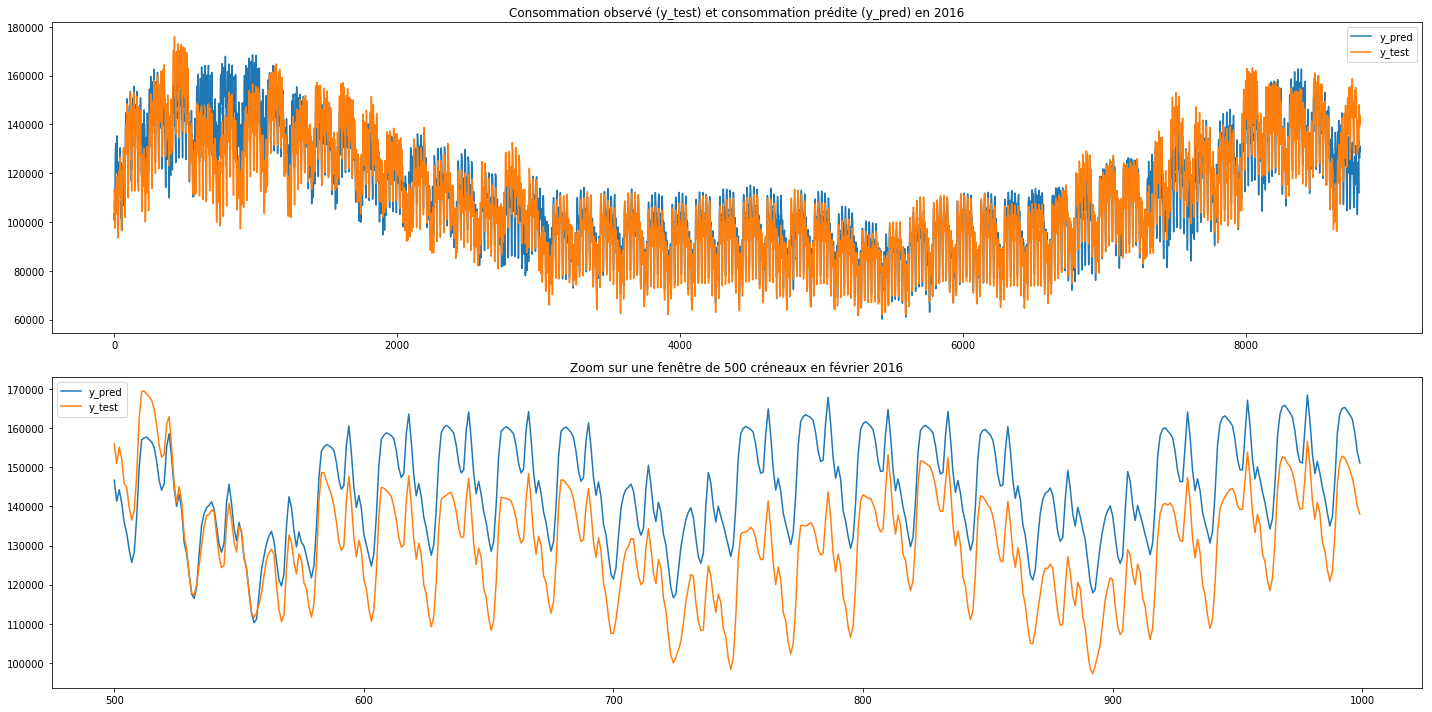

In [23]:
f, ax = plt.subplots(2,1, figsize=(20,10))
res = pd.DataFrame({'y_test': y_test, 'y_pred': preds})
res.plot(ax=ax[0]).set_title('Consommation observé (y_test) et consommation prédite (y_pred) en 2016')
res[500:1000].plot(ax=ax[1]).set_title('Zoom sur une fenêtre de 500 créneaux en février 2016')
plt.tight_layout()
plt.show()

Pas mal, même si nous sommes au-dessus du réel pour février. Jetons un coup d'oeil à la relation entre valeurs estimées et erreurs résiduelles de notre jeu d'entraînement.

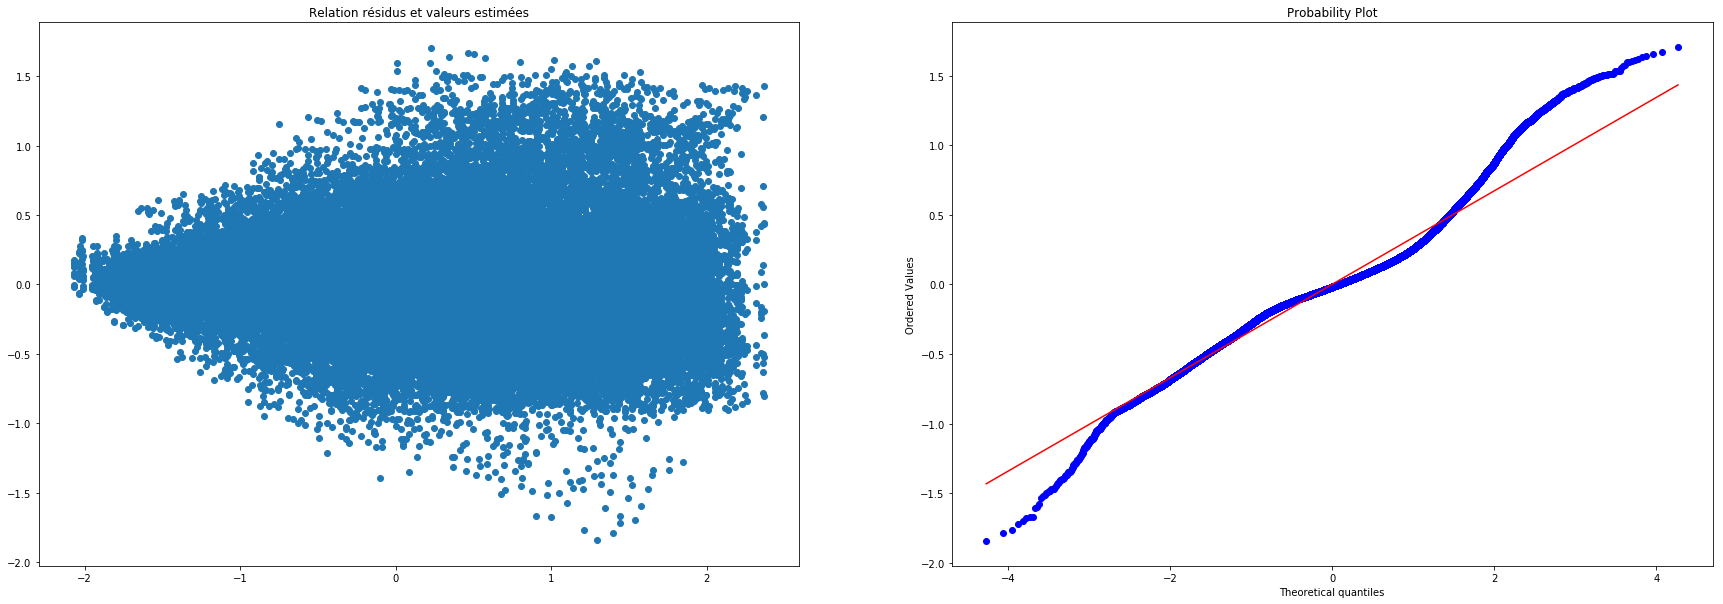

In [24]:
f, ax = plt.subplots(1,2, figsize=(30,10))
est = mlr.predict(X_train)
residues = ys_train - est
ax[0].scatter(est, residues)

from scipy import stats
stats.probplot(residues, plot=ax[1])
ax[0].set_title("Relation résidus et valeurs estimées")
plt.show()

L'erreur se répartie de manière symétrique autour de zéro et n'est pas trop loin d'une distribution normale. Le modèle semble bon.

Comment aller plus loin ?

1- J'ai testé 2016 à partir des données des huits années précédentes, mais est-ce pertinent de prendre tout l'historique ? Peut-être que 2016 se décrirait mieux à partir des années proches ?

2- La simple modélisation de la saisonnalité permet d'expliquer très bien la 
consommation électrique. Avec le MLR, il est très facile d'ajouter et de tester d'autres paramètres.

### Tester le modèle avec des fenêtres glissantes
Utilisons le *mape* comme critère d'optimalité. Nous sommes bien sur limité par la taille de l'historique. Nous allons tester 2014, 2015, 2016 et 2017 avec de 1 à 6 années antérieures pour l'entraînement.

In [25]:
scores = pd.DataFrame(index=range(1,7), columns=range(2014, 2018))
for year in range(2014, 2018):
    for testsize in range(1,7):
        # Selection des fenêtres d'entrainement et de test
        tr_start = '{}-01-01'.format(year - testsize)
        ts_start = '{}-01-01'.format(year)
        ts_end = '{}-01-01'.format(year+1)
        
        X_train, X_test = X[tr_start:ts_start], X[ts_start:ts_end]
        ys_train, ys_test = ys[tr_start:ts_start], ys[ts_start:ts_end] 
        
        mlr = lr(fit_intercept = False).fit(X_train, ys_train)
        preds = mlr.predict(X_test)
        
        preds = scaler.inverse_transform(preds)
        y_test = scaler.inverse_transform(ys_test)
        scores.loc[testsize, year] = print_error_measures(y_test, preds, show = False)[3]
        
np.round(scores, 2)

,2014,2015,2016,2017
1,8.33983,6.37342,7.1757,6.49997
2,7.11502,5.44582,6.18258,6.79303
3,6.00859,5.16949,5.69999,6.47402
4,6.92694,5.0711,5.47762,6.64955
5,6.5701,5.34381,5.23317,6.50188
6,6.50786,5.16081,5.17638,6.28271


Apparemment, il vaut mieux entraîner avec les six années antérieures. Le mape était encore meilleur pour 2016 avec les huit années d'entraînements.

### Améliorer le modèle en ajoutant d'autre variables.
Je vais essayer d'améliorer la précision en ajoutant une variable suceptible d'influencer la consommation électrique : la température. J'utilise un jeu de donnée qui remonte jusqu'à 2010, pour prédire 2016 puis 2017 avec six années d'entraînements, fourni par Météo France ici : https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

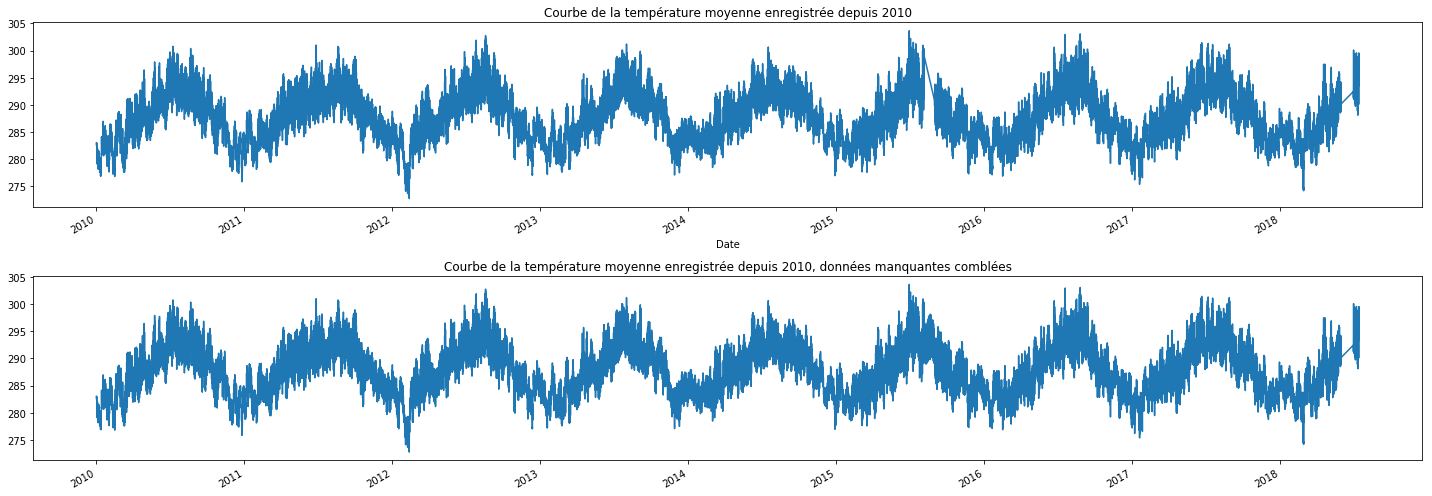

In [26]:
meteo = pd.read_csv("./donnees-synop-essentielles-omm.csv", 
                    sep=";",
                    header=0,
                    names=['Date', 'T'],
                    usecols=[1,7])

meteo['T'] = meteo['T'].astype('float')
meteo['Date'] = pd.to_datetime(meteo['Date'])
meteo = meteo.groupby('Date').mean()

f, ax = plt.subplots(2,1, figsize=(20,7))
meteo['T'].plot(ax=ax[0]).set_title('Courbe de la température moyenne enregistrée depuis 2010')

# Il manque les données du 7 au 30 août 2015, je les remplace par la moyenne du même créneau sur chaque année.
aout = meteo[(meteo.index.month == 8) & (meteo.index.day >= 7) & (meteo.index.day <= 30)].copy()
aout['creneau'] = '2015-' + aout.index.month.astype('str') + '-' + aout.index.day.astype('str') + 'T' + aout.index.time.astype('str')
aout = aout.groupby(by='creneau').mean()
aout.index = pd.to_datetime(aout.index)
meteo = pd.concat([aout, meteo], axis = 0)

meteo['T'].plot(ax=ax[1]).set_title('Courbe de la température moyenne enregistrée depuis 2010, données manquantes comblées')
plt.tight_layout()
plt.show()

# Ré-échantillonnage sur 1h 
meteo = meteo.resample('H').mean().fillna(method='ffill')

# Je normalise la variable.
meteo['T'] = (meteo['T'] - meteo['T'].mean()) / meteo['T'].std()

# Je l'ajoute à la matrice au moyen d'une jointure sur les dates. Je fais une jointure
# interne pour dégager les parties non recouvrantes du jeu de donnée.
X_meteo = X.merge(meteo, how='inner', left_index=True, right_index=True)

R Squared: 92.88 %
mse: mean squared error; rmse: root mean squared error ; mae: mean absolute error; mape: mean absolute percentage error; wape: weighted absolute percentage error


Measure|Value
--|--
mse|44169981.83
rmse|6646.05
mae|4958.76
mape|4.53 %
wape|4.53 %


R Squared: 93.48 %
mse: mean squared error; rmse: root mean squared error ; mae: mean absolute error; mape: mean absolute percentage error; wape: weighted absolute percentage error


Measure|Value
--|--
mse|55798091.36
rmse|7469.81
mae|5994.85
mape|5.48 %
wape|5.48 %


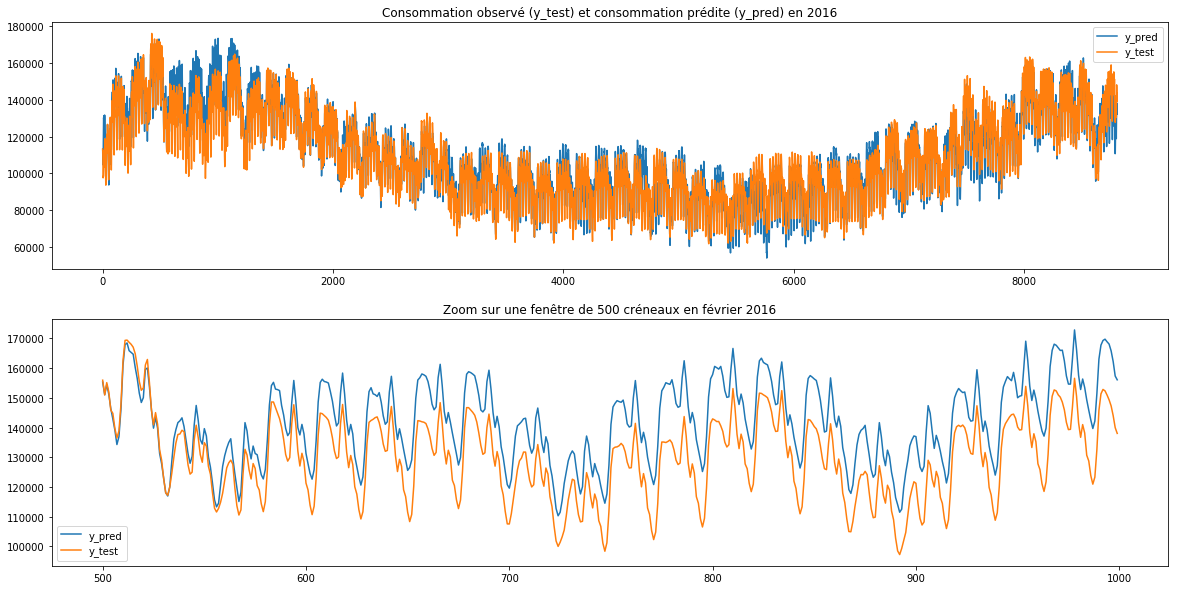

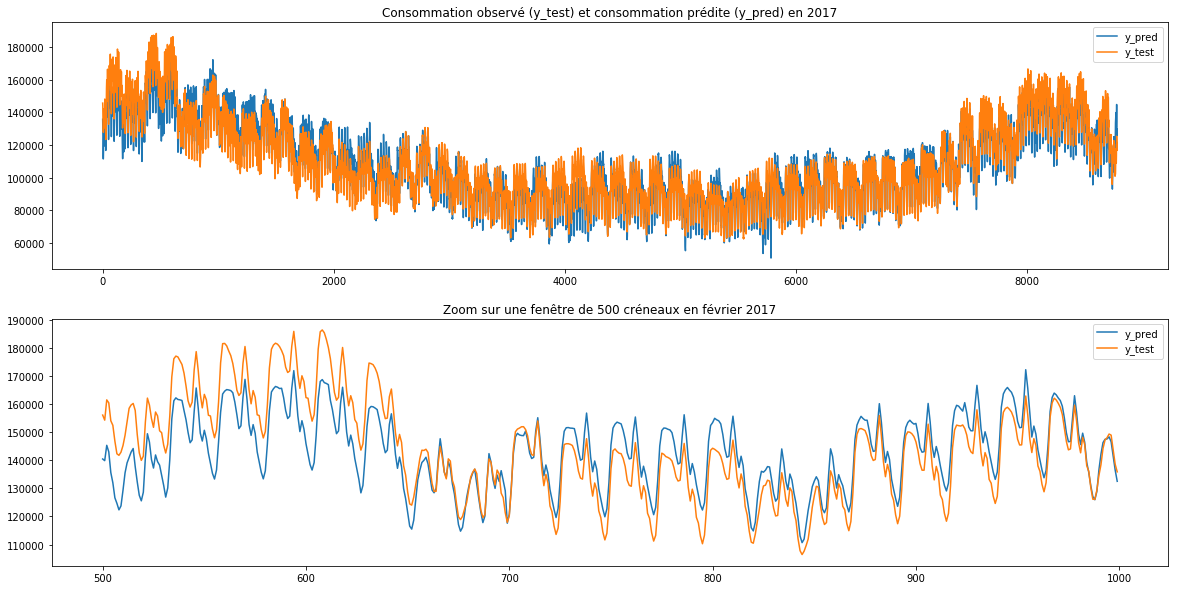

In [27]:
for year in [2016, 2017]:
    tr_start = '{}-01-01'.format(year - 6)
    ts_start = '{}-01-01'.format(year)
    ts_end = '{}-01-01'.format(year+1)
        
    X_train, X_test = X_meteo[tr_start:ts_start], X_meteo[ts_start:ts_end]
    ys_train, ys_test = ys[tr_start:ts_start], ys[ts_start:ts_end] 
    
    mlr = lr(fit_intercept = False).fit(X_train, ys_train)
    print("R Squared: {} %".format(round(mlr.score(X_train, ys_train) * 100, 2)))

    preds = mlr.predict(X_test)
    preds = scaler.inverse_transform(preds)
    y_test = scaler.inverse_transform(ys_test)
    print_error_measures(y_test, preds)

    f, ax = plt.subplots(2,1, figsize=(20,10))
    res = pd.DataFrame({'y_test': y_test, 'y_pred': preds})
    res.plot(ax=ax[0]).set_title('Consommation observé (y_test) et consommation prédite (y_pred) en {}'.format(year))
    res[500:1000].plot(ax=ax[1]).set_title('Zoom sur une fenêtre de 500 créneaux en février {}'.format(year))

L'ajout des températures moyennes améliorent légèrement la précision (d'environ 0.75 %) ! On imagine que la variation des températures est en bonne partie corrélée à la saisonnalité annuelle déjà modélisée, mais tout gain de précision est bon à prendre (si le modèle reste généraliste). Naturellement, l'exemple est artificiel puisqu'il s'appuie sur l'enregistrement précis des températures de l'année à prédire, mais le principe est là.

<div style="text-align: right">Clément SCHNEIDER<br/><i>Data Scientist</i><br/>
Novagen </div>